# PVAnalytics QA Process: Irradiance

In [2]:
import pvanalytics
import numpy as np
import rdtools
from statistics import mode
import json
# pvanalytics.__version__
from pvanalytics.features.clearsky import reno       #update to just do a pvanalytics import?
import pvlib
import matplotlib.pyplot as plt
import pandas as pd
from pvanalytics.quality import data_shifts as ds
from pvanalytics.quality import gaps
from pvanalytics.quality.outliers import zscore
from pvanalytics.features.daytime import power_or_irradiance
from pvanalytics.quality.time import shifts_ruptures
from pvanalytics.features import daytime
from pvanalytics.system import (is_tracking_envelope,
                                infer_orientation_fit_pvwatts)
from pvanalytics.features.clipping import geometric
import ruptures as rpt
import os
import boto3

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

In the following example, a process for assessing the data quality of an irradiance data stream is shown, using PVAnalytics functions. This example pipeline illustrates how several PVAnalytics functions can be used in sequence to assess the quality of an irradiance data stream.

First, we download and import the irradiance data from a PV installation under the [2023 solar data prize data set](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&limit=100&prefix=pvdaq%2F2023-solar-data-prize%2F). This data set is publicly available via the PVDAQ database in the DOE Open Energy Data Initiative (OEDI) (https://data.openei.org/submissions/4568), under system ID 2107. This data is timezone-localized.

In [3]:
with open('./data/2107_system_metadata.json', 'r') as f:
    metadata = json.load(f)
    
tz = metadata['System']['timezone_code']
 
def load_csv(file_path):
    df = pd.read_csv(
        file_path,
        index_col=0,
        parse_dates=True,
    )
    return df

df_irrad = load_csv("./data/2107_irradiance_data.csv")

df_irrad = df_irrad.tz_localize(tz, ambiguous=True)

latitude = metadata['Site']['latitude']
longitude = metadata['Site']['longitude']

# Get irradiance column and turn it into a series
# irradiance is sampled every 5 minutes 
irradiance_time_series = df_irrad['poa_irradiance_o_149574'].copy()

# Get the time frequency of the time series
freq_minutes = mode(irradiance_time_series.index.to_series().diff().dt.seconds / 60)
data_freq = str(freq_minutes) + "min"
irradiance_time_series = irradiance_time_series.asfreq(data_freq)

First, let’s visualize the original time series as reference.

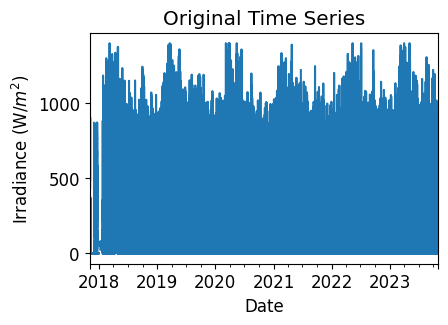

In [4]:
irradiance_time_series.plot(title="Original Time Series")
plt.xlabel("Date")
plt.ylabel("Irradiance " + f"(W/$m^2$)")
plt.show()

# Run Basic Data Checks

Now, let’s run basic data checks to identify stale and abnormal/outlier data in the time series. Basic data checks include the following steps:

1) Flatlined/stale data periods [(pvanalytics.quality.gaps.stale_values_round())](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.gaps.stale_values_round.html#pvanalytics.quality.gaps.stale_values_round)
2) Negative irradiance data
3) “Abnormal” data periods, which are defined as less than 10% of the daily time series mean OR greater than 1300
4) Outliers, which are defined as more than one 4 standard deviations away from the mean [(pvanalytics.quality.outliers.zscore())](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.outliers.zscore.html#pvanalytics.quality.outliers.zscore)

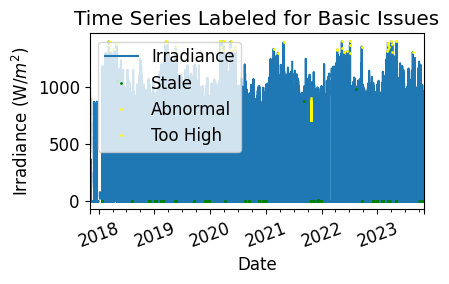

In [5]:
# REMOVE STALE DATA (that isn't during nighttime periods)
# Day/night mask
daytime_mask = power_or_irradiance(irradiance_time_series)
# Stale data mask
stale_data_mask = gaps.stale_values_round(irradiance_time_series,
                                          window=3,
                                          decimals=2)
stale_data_mask = stale_data_mask & daytime_mask

# REMOVE NEGATIVE DATA
negative_mask = (irradiance_time_series < 0)

# FIND ABNORMAL PERIODS
daily_min = irradiance_time_series.resample('D').min()
erroneous_mask = (daily_min > 50)
erroneous_mask = erroneous_mask.reindex(index=irradiance_time_series.index,
                                        method='ffill',
                                        fill_value=False)

# Remove values greater than or equal to 1300
out_of_bounds_mask = (irradiance_time_series >= 1300)

# FIND OUTLIERS (Z-SCORE FILTER)
zscore_outlier_mask = zscore(irradiance_time_series,
                             zmax=4,
                             nan_policy='omit')

# Get the percentage of data flagged for each issue, so it can later be logged
pct_stale = round((len(irradiance_time_series[
    stale_data_mask].dropna())/len(irradiance_time_series.dropna())*100), 1)
pct_negative = round((len(irradiance_time_series[
    negative_mask].dropna())/len(irradiance_time_series.dropna())*100), 1)
pct_erroneous = round((len(irradiance_time_series[
    erroneous_mask].dropna())/len(irradiance_time_series.dropna())*100), 1)
pct_outlier = round((len(irradiance_time_series[
    zscore_outlier_mask].dropna())/len(irradiance_time_series.dropna())*100), 1)

# Visualize all of the time series issues (stale, abnormal, outlier, etc)
irradiance_time_series.plot()
labels = ["Irradiance"]
if any(stale_data_mask):
    irradiance_time_series.loc[stale_data_mask].plot(ls='', marker='o', color="green")
    labels.append("Stale")
if any(negative_mask):
    irradiance_time_series.loc[negative_mask].plot(ls='', marker='o', color="orange")
    labels.append("Negative")
if any(erroneous_mask):
    irradiance_time_series.loc[erroneous_mask].plot(ls='', marker='o', color="yellow")
    labels.append("Abnormal")
if any(out_of_bounds_mask):
    irradiance_time_series.loc[out_of_bounds_mask].plot(ls='', marker='o', color="yellow")
    labels.append("Too High")
if any(zscore_outlier_mask):
    irradiance_time_series.loc[zscore_outlier_mask].plot(
        ls='', marker='o', color="purple")
    labels.append("Outlier")
plt.legend(labels=labels)
plt.title("Time Series Labeled for Basic Issues")
plt.xticks(rotation=20)
plt.xlabel("Date")
plt.ylabel("Irradiance " + f"(W/$m^2$)")
plt.tight_layout()
plt.show()

Now, let’s filter out any of the flagged data from the basic irradiance checks (stale or abnormal data).

In [6]:
# Filter the time series, taking out all of the issues
issue_mask = ((~stale_data_mask) & (~negative_mask) & (~erroneous_mask) &
              (~out_of_bounds_mask) & (~zscore_outlier_mask))
irradiance_time_series = irradiance_time_series[issue_mask].copy()

irradiance_time_series = irradiance_time_series.asfreq(data_freq)

# Daily Completeness Check

We filter the time series based on its daily completeness score. This filtering scheme requires at least 25% of data to be present for each day to be included.

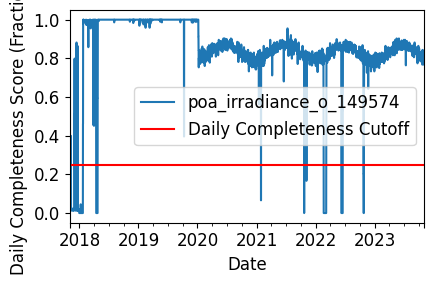

In [7]:
# Visualize daily data completeness
data_completeness_score = gaps.completeness_score(irradiance_time_series)

# Visualize data completeness score as a time series.
data_completeness_score.plot()
plt.xlabel("Date")
plt.ylabel("Daily Completeness Score (Fractional)")
plt.axhline(y=0.25, color='r', linestyle='-',
            label='Daily Completeness Cutoff')
plt.legend()
plt.tight_layout()
plt.show()

# Trim the series based on daily completeness score
trim_series_mask = pvanalytics.quality.gaps.trim_incomplete(
    irradiance_time_series,
    minimum_completeness=.25,
    freq=data_freq)

irradiance_time_series = irradiance_time_series[trim_series_mask]

# Time Shift Check

Next, we check the time series for any time shifts, which may be caused by time drift or by incorrect time zone assignment. To do this, we compare the modelled midday time for the particular system location to its measured midday time. We use [pvanalytics.quality.gaps.stale_values_round()](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.gaps.stale_values_round.html#pvanalytics.quality.gaps.stale_values_round) to determine the presence of time shifts in the series.

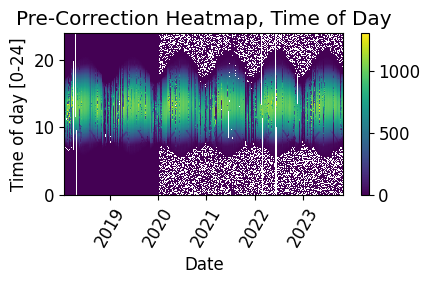

In [8]:
# Plot the heatmap of the irradiance time series before time shift correction.
plt.figure()
# Get time of day from the associated datetime column
time_of_day = pd.Series(irradiance_time_series.index.hour +
                        irradiance_time_series.index.minute/60,
                        index=irradiance_time_series.index)
# Pivot the dataframe
dataframe = pd.DataFrame(pd.concat([irradiance_time_series, time_of_day], axis=1))
dataframe.columns = ["values", 'time_of_day']
dataframe = dataframe.dropna()
dataframe_pivoted = dataframe.pivot_table(index='time_of_day',
                                          columns=dataframe.index.date,
                                          values="values")
plt.pcolormesh(dataframe_pivoted.columns,
               dataframe_pivoted.index,
               dataframe_pivoted,
               shading='auto')
plt.ylabel('Time of day [0-24]')
plt.xlabel('Date')
plt.xticks(rotation=60)
plt.title('Pre-Correction Heatmap, Time of Day')
plt.colorbar()
plt.tight_layout()
plt.show()

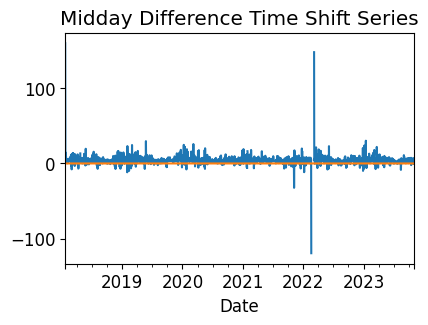

In [9]:
# Get the modeled sunrise and sunset time series based on the system's
# latitude-longitude coordinates
modeled_sunrise_sunset_df = pvlib.solarposition.sun_rise_set_transit_spa(
     irradiance_time_series.index, latitude, longitude)

# Calculate the midday point between sunrise and sunset for each day
# in the modeled irradiance series
modeled_midday_series = modeled_sunrise_sunset_df['sunrise'] + \
    (modeled_sunrise_sunset_df['sunset'] -
     modeled_sunrise_sunset_df['sunrise']) / 2

# Run day-night mask on the irradiance time series
daytime_mask = power_or_irradiance(irradiance_time_series,
                                   freq=data_freq,
                                   low_value_threshold=.005)

# Generate the sunrise, sunset, and halfway points for the data stream
sunrise_series = daytime.get_sunrise(daytime_mask)
sunset_series = daytime.get_sunset(daytime_mask)
midday_series = sunrise_series + ((sunset_series - sunrise_series)/2)

# Convert the midday and modeled midday series to daily values
midday_series_daily, modeled_midday_series_daily = (
    midday_series.resample('D').mean(),
    modeled_midday_series.resample('D').mean())

# Set midday value series as minutes since midnight, from midday datetime
# values
midday_series_daily = (midday_series_daily.dt.hour * 60 +
                       midday_series_daily.dt.minute +
                       midday_series_daily.dt.second / 60)
modeled_midday_series_daily = \
    (modeled_midday_series_daily.dt.hour * 60 +
     modeled_midday_series_daily.dt.minute +
     modeled_midday_series_daily.dt.second / 60)

# Estimate the time shifts by comparing the modelled midday point to the
# measured midday point.
is_shifted, time_shift_series = shifts_ruptures(midday_series_daily,
                                                modeled_midday_series_daily,
                                                period_min=15,
                                                shift_min=15,
                                                zscore_cutoff=1.5)

# Create a midday difference series between modeled and measured midday, to
# visualize time shifts. First, resample each time series to daily frequency,
# and compare the data stream's daily halfway point to the modeled halfway
# point
midday_diff_series = (midday_series.resample('D').mean() -
                      modeled_midday_series.resample('D').mean()
                      ).dt.total_seconds() / 60

# Generate boolean for detected time shifts
if any(time_shift_series != 0):
    time_shifts_detected = True
else:
    time_shifts_detected = False

# Build a list of time shifts for re-indexing. We choose to use dicts.
time_shift_series.index = pd.to_datetime(
    time_shift_series.index)
changepoints = (time_shift_series != time_shift_series.shift(1))
changepoints = changepoints[changepoints].index
changepoint_amts = pd.Series(time_shift_series.loc[changepoints])
time_shift_list = list()
for idx in range(len(changepoint_amts)):
    if changepoint_amts[idx] == 0:
        change_amt = 0
    else:
        change_amt = -1 * changepoint_amts[idx]
    if idx < (len(changepoint_amts) - 1):
        time_shift_list.append({"datetime_start":
                                str(changepoint_amts.index[idx]),
                                "datetime_end":
                                    str(changepoint_amts.index[idx + 1]),
                                "time_shift": change_amt})
    else:
        time_shift_list.append({"datetime_start":
                                str(changepoint_amts.index[idx]),
                                "datetime_end":
                                    str(time_shift_series.index.max()),
                                "time_shift": change_amt})
    
# Correct any time shifts in the time series
new_index = pd.Series(irradiance_time_series.index, index=irradiance_time_series.index).dropna()
for i in time_shift_list:
    if pd.notna(i['time_shift']):
        new_index[(irradiance_time_series.index >= pd.to_datetime(i['datetime_start'])) &
              (irradiance_time_series.index < pd.to_datetime(i['datetime_end']))] = \
        irradiance_time_series.index + pd.Timedelta(minutes=i['time_shift'])
irradiance_time_series.index = new_index

# Remove duplicated indices and sort the time series (just in case)
irradiance_time_series = irradiance_time_series[~irradiance_time_series.index.duplicated(
    keep='first')].sort_index()

# Plot the difference between measured and modeled midday, as well as the
# CPD-estimated time shift series.
plt.figure()
midday_diff_series.plot()
time_shift_series.plot()
plt.title("Midday Difference Time Shift Series")
plt.xlabel("Date")
plt.show()

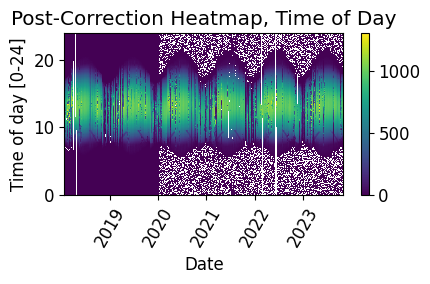

In [10]:
# Plot the heatmap of the irradiance time series
plt.figure()
# Get time of day from the associated datetime column
time_of_day = pd.Series(irradiance_time_series.index.hour +
                        irradiance_time_series.index.minute/60,
                        index=irradiance_time_series.index)
# Pivot the dataframe
dataframe = pd.DataFrame(pd.concat([irradiance_time_series, time_of_day], axis=1))
dataframe.columns = ["values", 'time_of_day']
dataframe = dataframe.dropna()
dataframe_pivoted = dataframe.pivot_table(index='time_of_day',
                                          columns=dataframe.index.date,
                                          values="values")
plt.pcolormesh(dataframe_pivoted.columns,
               dataframe_pivoted.index,
               dataframe_pivoted,
               shading='auto')
plt.ylabel('Time of day [0-24]')
plt.xlabel('Date')
plt.xticks(rotation=60)
plt.title('Post-Correction Heatmap, Time of Day')
plt.colorbar()
plt.tight_layout()
plt.show()

# Data/Capacity Shift Check

Next, we check the time series for any abrupt data shifts. We take the longest continuous part of the time series that is free of data shifts. We use [pvanalytics.quality.data_shifts.detect_data_shifts()](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.data_shifts.detect_data_shifts.html#pvanalytics.quality.data_shifts.detect_data_shifts) to detect data shifts in the time series.

In [11]:
# Set all values in the nighttime mask to 0
irradiance_time_series.loc[~daytime_mask] = 0
# Resample the time series to daily mean
irradiance_time_series_daily = irradiance_time_series.resample('D').mean()
data_shift_start_date, data_shift_end_date = ds.get_longest_shift_segment_dates(irradiance_time_series_daily,
                                                                                use_default_models=False,
                                                                                method=rpt.Binseg, cost='rbf',
                                                                                penalty=20)
data_shift_period_length = (data_shift_end_date - data_shift_start_date).days

# Get the number of shift dates
data_shift_mask = ds.detect_data_shifts(irradiance_time_series_daily,
                                        use_default_models=False,
                                        method=rpt.Binseg, cost='rbf',
                                        penalty=20)
# Get the shift dates
shift_dates = list(irradiance_time_series_daily[data_shift_mask].index)
if len(shift_dates) > 0:
    shift_found = True
else: 
    shift_found = False
    
irradiance_time_series = irradiance_time_series[
        (irradiance_time_series.index >=
         data_shift_start_date.tz_convert(irradiance_time_series.index.tz)) &
        (irradiance_time_series.index <=
         data_shift_end_date.tz_convert(irradiance_time_series.index.tz))]

irradiance_time_series = irradiance_time_series.asfreq(data_freq)

Shift Found:  False


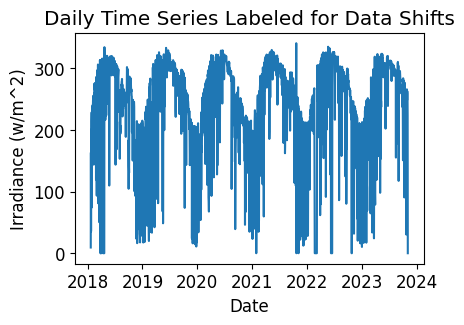

In [12]:
# Visualize the time shifts for the daily time series
print("Shift Found: ", shift_found)
edges = ([irradiance_time_series_daily.index[0]] + shift_dates +
         [irradiance_time_series_daily.index[-1]])
fig, ax = plt.subplots()
for (st, ed) in zip(edges[:-1], edges[1:]):
    ax.plot(irradiance_time_series_daily.loc[st:ed])
plt.title("Daily Time Series Labeled for Data Shifts")
plt.xlabel("Date")
plt.ylabel("Irradiance (w/m^2)")
plt.show()

# Final Filtered Irradiance Series

Display the final irradiance time series, post-QA filtering.

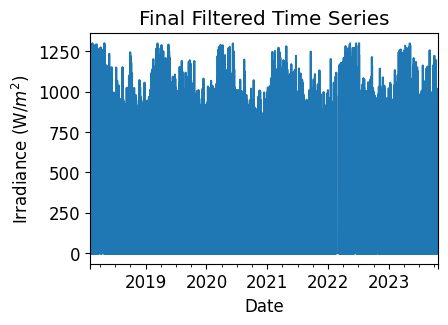

In [13]:
irradiance_time_series.plot(title="Final Filtered Time Series")
plt.xlabel("Date")
plt.ylabel("Irradiance " + f"(W/$m^2$)")
plt.show()
plt.close()

irradiance_time_series.to_pickle("./data/poa_irradiance_o_149574.pkl")

Generate a dictionary output for the QA assessment of this data stream, including the percent stale and erroneous data detected, any shift dates, and any detected time shifts.

In [14]:
qa_check_dict = {"original_time_zone_offset": irradiance_time_series.index.tz,
                 "pct_stale": pct_stale,
                 "pct_negative": pct_negative,
                 "pct_erroneous": pct_erroneous,
                 "pct_outlier": pct_outlier,
                 "time_shifts_detected": time_shifts_detected,
                 "time_shift_list": time_shift_list,
                 "data_shifts": shift_found,
                 "shift_dates": shift_dates}

print("QA Results:")
print(qa_check_dict)

QA Results:
{'original_time_zone_offset': <DstTzInfo 'PST8PDT' PST-1 day, 16:00:00 STD>, 'pct_stale': 0.0, 'pct_negative': 0.0, 'pct_erroneous': 0.0, 'pct_outlier': 0.0, 'time_shifts_detected': False, 'time_shift_list': [{'datetime_start': '2018-01-22 00:00:00-08:00', 'datetime_end': '2023-11-01 00:00:00-07:00', 'time_shift': 0}], 'data_shifts': False, 'shift_dates': []}


Total running time of the irradiance time series QA script: 1 min, 25 sec